SPEECH ENHANCEMENT USING MAMBA

In [1]:
import pickle
output_file = "/scratchSSD2/databaseTFM/audio_tuple_5k_5dB.pkl"
with open(output_file, "rb") as f:
    audio_tuple = pickle.load(f)
    print(f"Loaded {len(audio_tuple)} audio segments from {output_file}")

Loaded 15364 audio segments from /scratchSSD2/databaseTFM/audio_tuple_5k_5dB.pkl


In [2]:
import librosa
import numpy as np
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

class AudioDataset(Dataset):
    def __init__(self, audio_data):
        """
        Args:
            metadata_file (str): Path to the file with audio file paths and labels.
            transform (callable, optional): Optional transform to apply on a sample.
        """
        self.audio_data = audio_data  

    def __len__(self):
        return len(self.audio_data)

    def __getitem__(self, idx):
        
        noisy_audio, clean_audio = self.audio_data[idx]
        # Load audio and calculate spectrogram from clean and noisy audio
        S_noisy = librosa.stft(noisy_audio, n_fft=512, hop_length=160, win_length=400)
        S_dB_noisy = librosa.amplitude_to_db(np.abs(S_noisy), ref=np.max)

        S_clean = librosa.stft(clean_audio, n_fft=512, hop_length=160, win_length=400)
        S_dB_clean = librosa.amplitude_to_db(np.abs(S_clean), ref=np.max)
        
        # Convert to tensor
        S_dB_noisy = torch.tensor(S_dB_noisy, dtype=torch.float32)
        S_dB_clean = torch.tensor(S_dB_clean, dtype=torch.float32)
        
        return S_dB_noisy, S_dB_clean

In [3]:
from torch.utils.data import DataLoader

audio_dataset = AudioDataset(audio_tuple)
audio_dataloader = DataLoader(audio_dataset, batch_size=32, shuffle=True)
print(len(audio_dataloader))

481


In [10]:
import torch
from mamba_ssm import Mamba2

class Net2(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        # Linear layer to project input features to hidden space
        self.linear1 = torch.nn.Linear(input_size, hidden_size)
        
        # Mamba SSM layer for sequence modeling
        self.mamba = Mamba2(
            d_model=hidden_size,  # Model dimension
            d_state=64,           # SSM state expansion factor
            d_conv=4,             # Local convolution width
            expand=2              # Block expansion factor
        )

        # Dropout for regularization
        self.drop = torch.nn.Dropout(0.1)
        
        # Final linear layer to project back to original frequency bins
        self.linear2 = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Linear transformation to hidden space
        x = self.linear1(x)
        
        # Mamba SSM for sequence modeling
        x = self.mamba(x)
        x = self.mamba(x)
        x = self.mamba(x)       
        
        # Dropout for regularization
        x = self.drop(x)
        
        # Output projection to original frequency bins
        x = self.linear2(x)
        
        return x



Training


In [5]:
import matplotlib.pyplot as plt

def train_model(model, dataloader, num_epochs=10, learning_rate=0.001):
    """
    Train the LSTM model.
    
    Args:
        model (nn.Module): The LSTM model to train.
        dataloader (DataLoader): DataLoader for training data.
        num_epochs (int): Number of training epochs.
        learning_rate (float): Learning rate for the optimizer.
    """

    J = torch.nn.MSELoss()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    J_it = np.zeros(num_epochs)

    for epoch in range(num_epochs):
        #model.train()  # Set the model to training model
        k = 0
        for noisy_audio, clean_audio in dataloader:
            
            noisy_audio = noisy_audio.transpose(1, 2).to(device)  # LSTM expects (batch, seq_len, input_size)
            clean_audio = clean_audio.transpose(1, 2).to(device)

            # Normalization
            noisy_audio = (noisy_audio - noisy_audio.mean()) / noisy_audio.std()
            clean_audio = (clean_audio - clean_audio.mean()) / clean_audio.std()
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            output = model(noisy_audio)
            
            # Compute the loss (MSE loss between predicted and clean spectrogram)
            loss = J(output, clean_audio)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            J_it[epoch] += loss.item()
            k += 1
        
        # Print the average loss for this epoch
        J_it[epoch] /= k
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {J_it[epoch]:.4f}")

    print("Training complete.")
    print(k)
    plt.clf()
    plt.plot(J_it,'b', markersize=8, linestyle='-', marker='.')
    plt.ylabel('J')
    plt.xlabel('it')
    plt.grid(True)


1024 64
Using device: cuda
Epoch 1/40, Loss: 0.2702
Epoch 2/40, Loss: 0.2269
Epoch 3/40, Loss: 0.2549
Epoch 4/40, Loss: 0.2188
Epoch 5/40, Loss: 0.2071
Epoch 6/40, Loss: 0.2005
Epoch 7/40, Loss: 0.1969
Epoch 8/40, Loss: 0.1975
Epoch 9/40, Loss: 0.1904
Epoch 10/40, Loss: 0.1887
Epoch 11/40, Loss: 0.1835
Epoch 12/40, Loss: 0.1853
Epoch 13/40, Loss: 0.1963
Epoch 14/40, Loss: 0.1781
Epoch 15/40, Loss: 0.2086
Epoch 16/40, Loss: 0.1784
Epoch 17/40, Loss: 0.1756
Epoch 18/40, Loss: 0.1724
Epoch 19/40, Loss: 0.1766
Epoch 20/40, Loss: 0.1767
Epoch 21/40, Loss: 0.2053
Epoch 22/40, Loss: 0.1749
Epoch 23/40, Loss: 0.1802
Epoch 24/40, Loss: 0.2712
Epoch 25/40, Loss: 0.2269
Epoch 26/40, Loss: 0.2006
Epoch 27/40, Loss: 0.1884
Epoch 28/40, Loss: 0.1835
Epoch 29/40, Loss: 0.1888
Epoch 30/40, Loss: 0.1803
Epoch 31/40, Loss: 0.1810
Epoch 32/40, Loss: 0.1808
Epoch 33/40, Loss: 0.1840
Epoch 34/40, Loss: 0.1742
Epoch 35/40, Loss: 0.1724
Epoch 36/40, Loss: 0.1699
Epoch 37/40, Loss: 0.1803
Epoch 38/40, Loss: 0

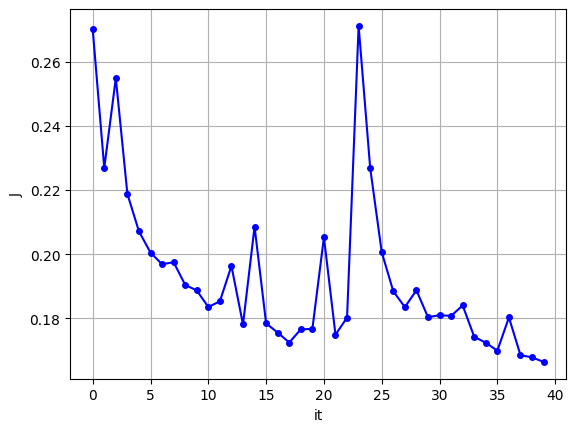

In [11]:
batch_size = 32
freq_bins = 257
time_steps = 501

input_size = freq_bins
hidden_size = 512  # Hidden size for Mamba layers
output_size = freq_bins  # Output should match the input spectrogram's frequency bins

model_mamba = Net2(input_size, hidden_size, output_size)

#Selecting cpu or gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Train the model
train_model(model_mamba.to(device), audio_dataloader, num_epochs=40, learning_rate=0.001)

In [ ]:
# Save weights of the model
torch.save(model_mamba, 'model_mamba_weights.pth')

In [ ]:
# Model class must be defined somewhere
model_mamba = torch.load('model_mamba_weights.pth', weights_only=False)
model_mamba.eval()

TESTING PHASE

In [12]:
import pickle
test_output_file = "/scratchSSD2/databaseTFM/test_audio_tuple.pkl"
with open(test_output_file, "rb") as f:
    test_audio_tuple = pickle.load(f)
    print(f"Loaded {len(test_audio_tuple)} audio segments from {test_output_file}")

Loaded 7860 audio segments from /scratchSSD2/databaseTFM/test_audio_tuple.pkl


In [13]:
from torch.utils.data import Subset
from torch.utils.data import DataLoader

# Select the first 10 samples
test_audio_dataset = AudioDataset(test_audio_tuple)
subset_indices = list(range(10))  # Indices for the first 10 samples
test_audio_subset = Subset(test_audio_dataset, subset_indices)

# Create the DataLoader
test_audio_dataloader = DataLoader(test_audio_subset, batch_size=1)

# Print the length of the DataLoader
print(len(test_audio_dataloader))  # Should print 10

10


In [14]:
import torch

def calculate_snr(clean_spectrogram, predicted_spectrogram):
    """
    Calculate the Signal-to-Noise Ratio (SNR) in decibels (dB).
    
    Args:
        clean_spectrogram (torch.Tensor): Clean spectrogram (desired signal).
        predicted_spectrogram (torch.Tensor): Predicted (or noisy) spectrogram.

    Returns:
        snr (float): Signal-to-Noise Ratio in dB.
    """
    # Convert spectrograms from dB to linear scale
    clean_linear = 10 ** (clean_spectrogram / 10)
    predicted_linear = 10 ** (predicted_spectrogram / 10)

    # Compute noise in linear scale
    noise_linear = clean_linear - predicted_linear

    noise_linear = 10 ** (noise_linear / 10)

    # Ensure noise values are non-negative
    noise_linear = torch.clamp(noise_linear, min=1e-10)  # to avoid divide-by-zero or log(0)


    # Compute the power (squared magnitude) of the clean signal and the noise
    signal_power = torch.sum(clean_linear ** 2)
    noise_power = torch.sum(predicted_linear ** 2)

    # Compute the SNR (in dB)
    snr = 10 * torch.log10(signal_power / noise_power)
    
    return snr.item()


torch.Size([1, 257, 501])


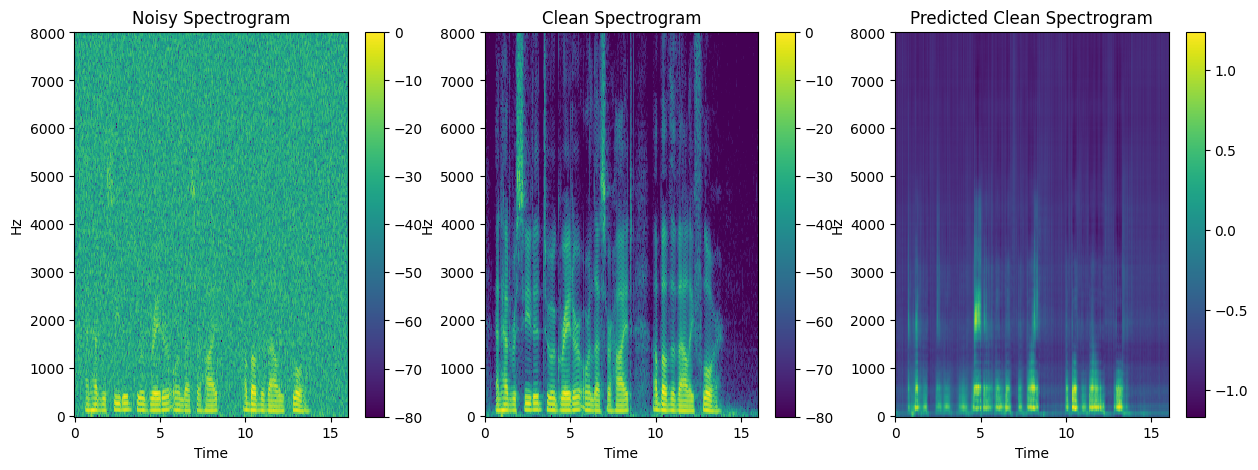

torch.Size([1, 257, 501])


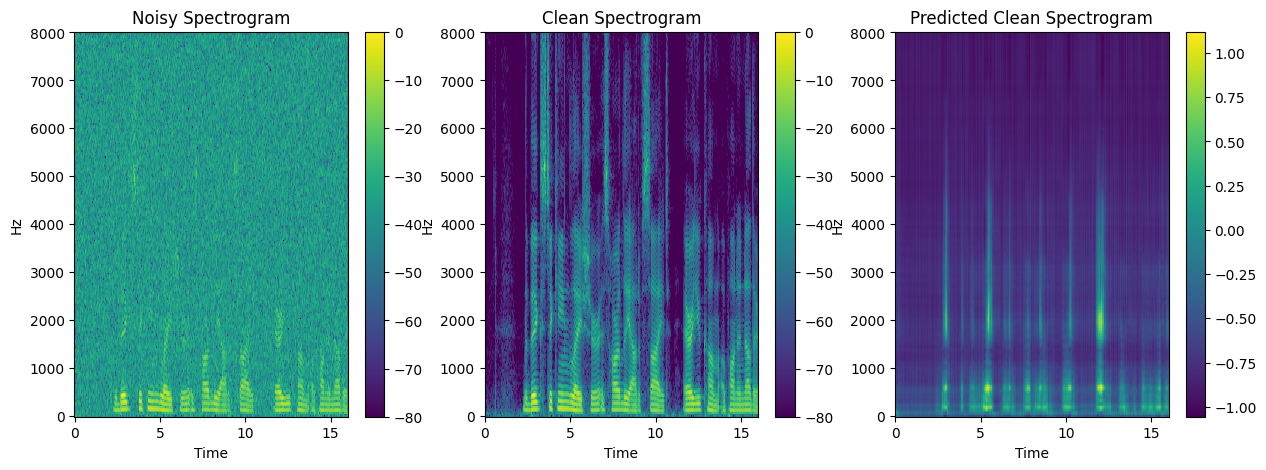

torch.Size([1, 257, 501])


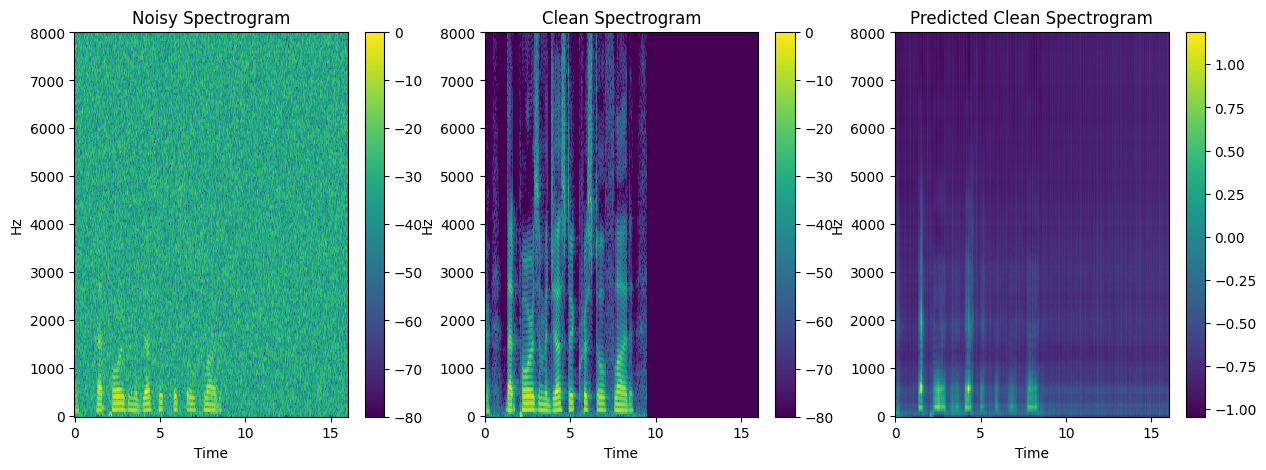

torch.Size([1, 257, 501])


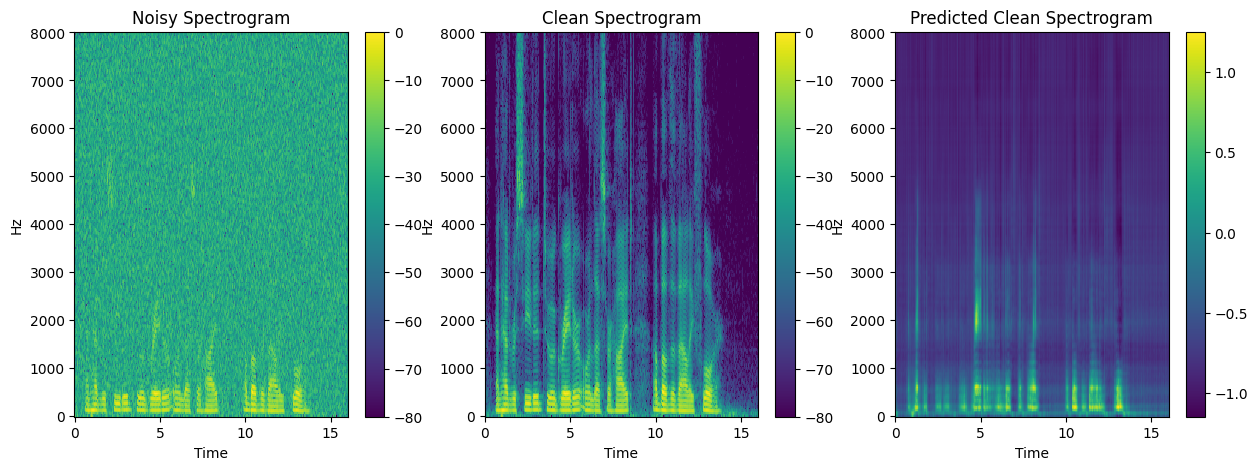

torch.Size([1, 257, 501])


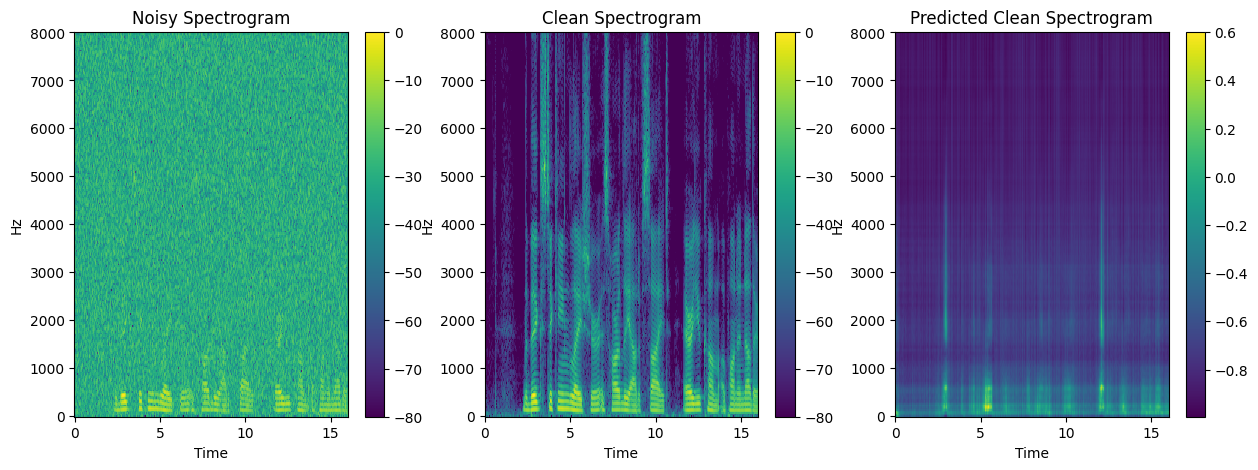

torch.Size([1, 257, 501])


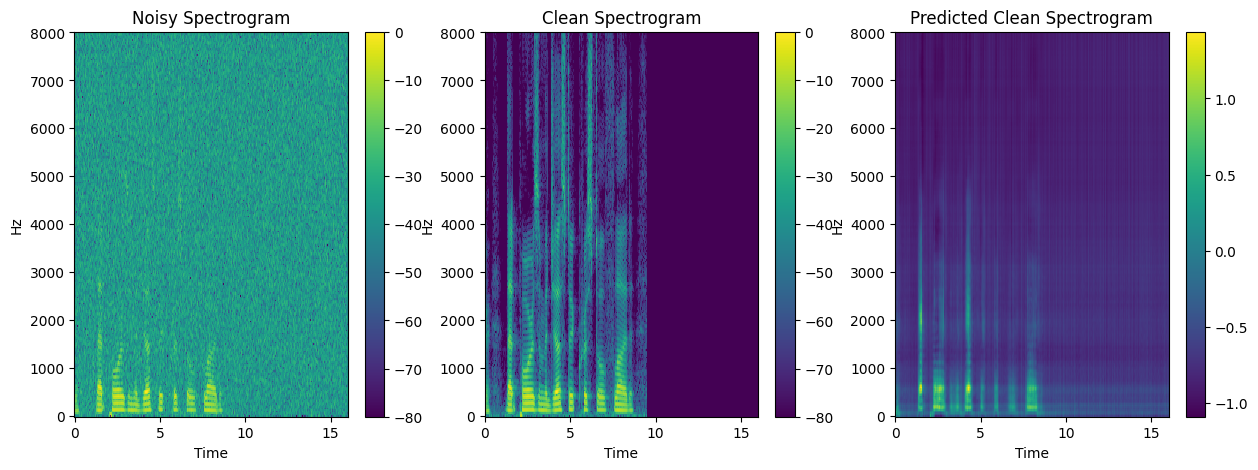

torch.Size([1, 257, 501])


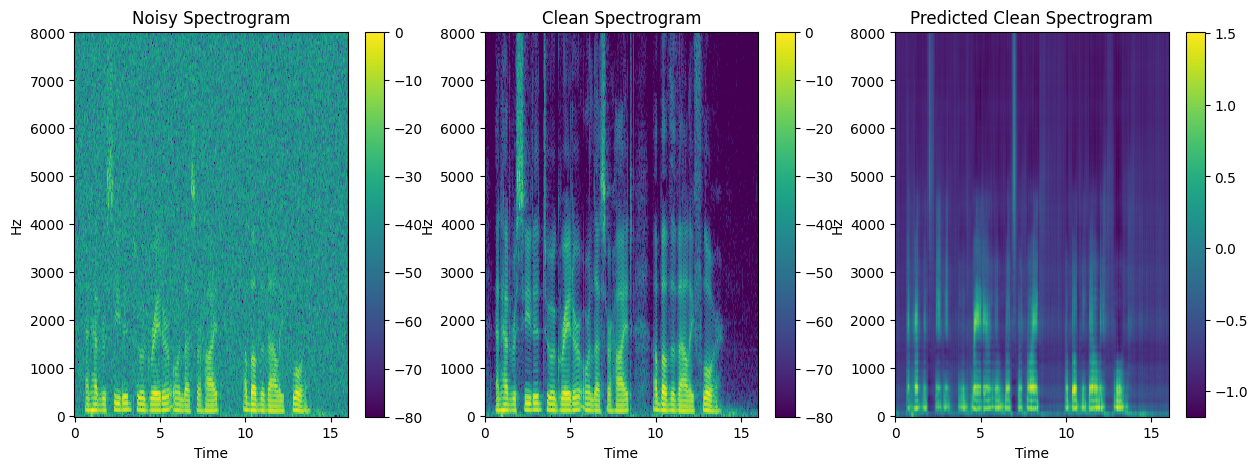

torch.Size([1, 257, 501])


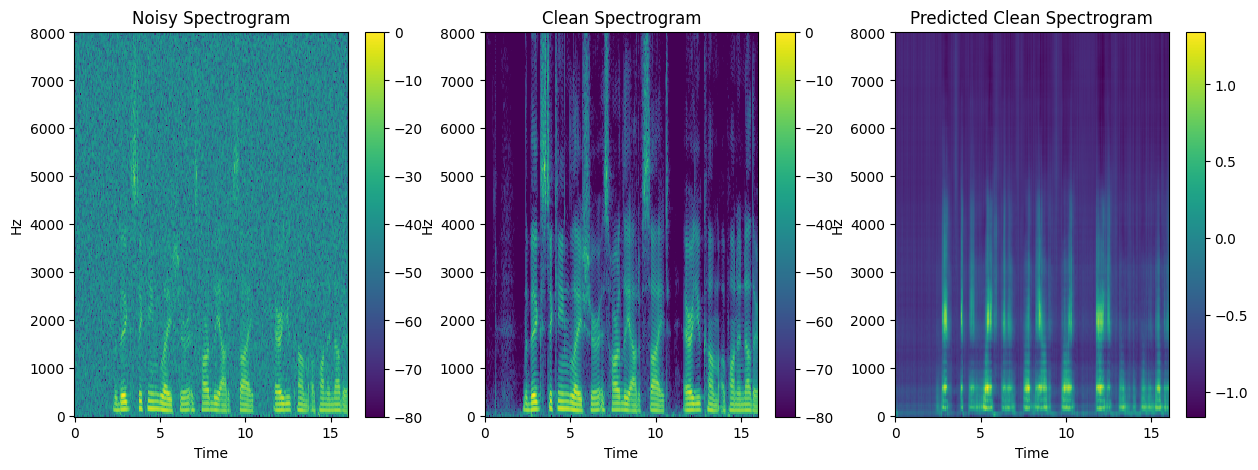

torch.Size([1, 257, 501])


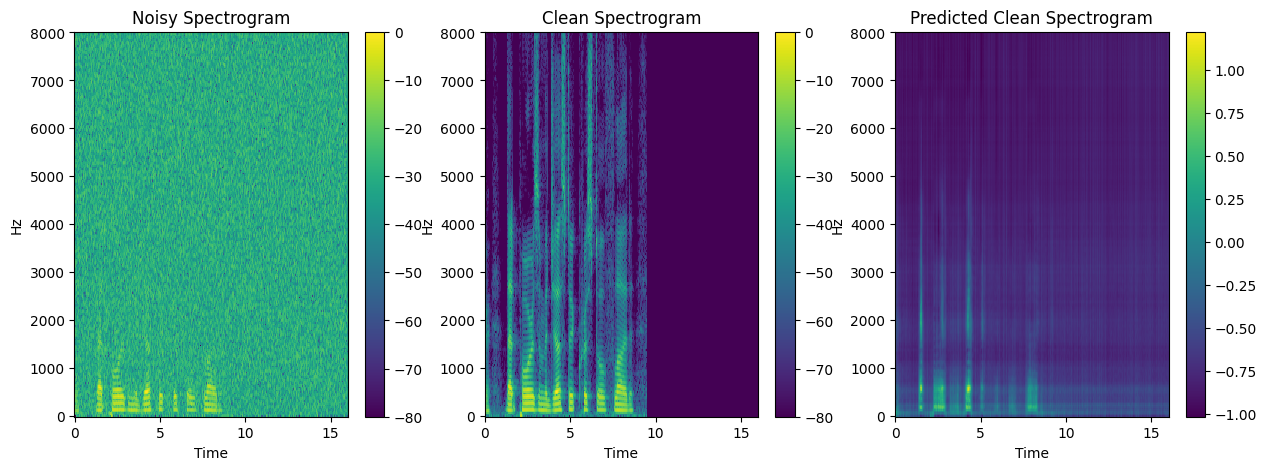

torch.Size([1, 257, 501])


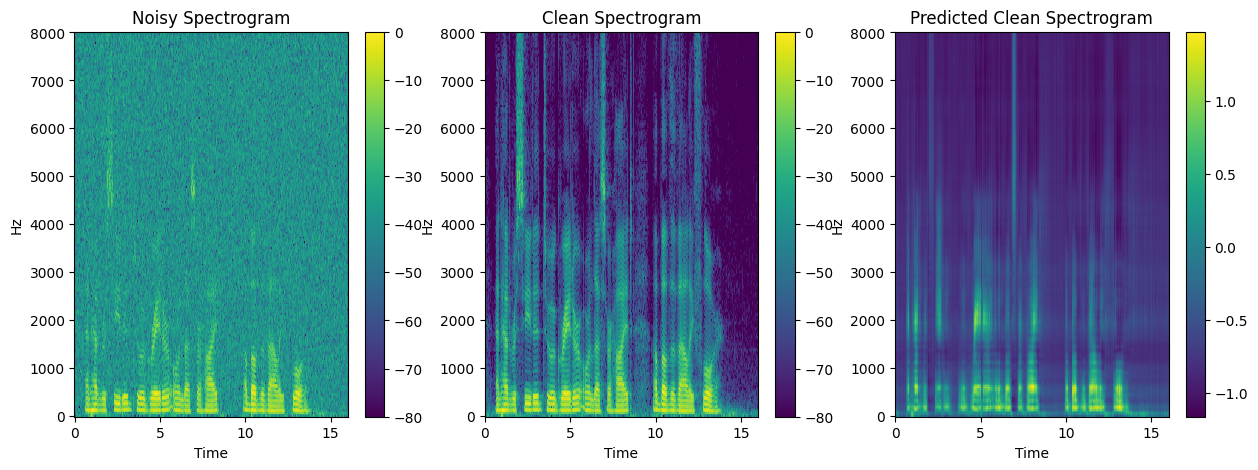

In [15]:
import librosa.display
import matplotlib.pyplot as plt

SAMPLE_RATE = 16000 

display = True

for noisy_spectrogram, clean_spectrogram in test_audio_dataloader:

    print(noisy_spectrogram.shape)
    noisy_spectrogram = noisy_spectrogram.transpose(1, 2).to(device) 
    clean_spectrogram = clean_spectrogram.to(device)

    # Forward pass through the model
    with torch.no_grad():
        predicted_spectrogram = model_mamba(noisy_spectrogram)

    # Move back to CPU for visualization
    noisy_spectrogram = noisy_spectrogram.transpose(1, 2).cpu()
    clean_spectrogram = clean_spectrogram.cpu()
    predicted_spectrogram = predicted_spectrogram.transpose(1, 2).cpu()

    #snr_value = calculate_snr(clean_spectrogram, predicted_spectrogram)
    #print(f"SNR: {snr_value} dB")


    if(display):
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        librosa.display.specshow(noisy_spectrogram[0].numpy(), sr=SAMPLE_RATE, x_axis="time", y_axis="hz", cmap="viridis")
        plt.colorbar()
        plt.title("Noisy Spectrogram")

        plt.subplot(1, 3, 2)
        librosa.display.specshow(clean_spectrogram[0].numpy(), sr=SAMPLE_RATE, x_axis="time", y_axis="hz", cmap="viridis")
        plt.colorbar()
        plt.title("Clean Spectrogram")

        plt.subplot(1, 3, 3)
        librosa.display.specshow(predicted_spectrogram[0].numpy(), sr=SAMPLE_RATE, x_axis="time", y_axis="hz", cmap="viridis")
        plt.colorbar()
        plt.title("Predicted Clean Spectrogram")

        plt.show()